## Building chatbot with multiple tools using langgraph

Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=5000)
arxiv= ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention is all you need")

"Published: 2021-05-07\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifically, we replace the attention layer in a vision transformer with a feed-forward layer applied over the patch dimension. The resulting architecture is simply a series of feed-forward layers applied over the patch and feature dimensions in an alternating fashion. In experiments on ImageNet, this architecture performs surprisingly well: a ViT/DeiT-base-sized model obtains 74.9\\% top-1 accuracy, compared to 77.9\\% and 79.9\\% for ViT and DeiT respectively. These results indicate that aspects

In [4]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki= WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [5]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
from langchain_tavily import TavilySearch
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv

load_dotenv()

# tavily = TavilySearch(
#     max_results=5,
#     topic="general",
#     # include_answer=False,
#     # include_raw_content=False,
#     # include_images=False,
#     # include_image_descriptions=False,
#     # search_depth="basic",
#     # time_range="day",
#     # include_domains=None,
#     # exclude_domains=None
# )

tavily = TavilySearchResults()

C:\Users\USER\AppData\Local\Temp\ipykernel_23948\1265755731.py:20: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [7]:
tavily.invoke({"query": "What happened at the last wimbledon"})

[{'title': '2025 Wimbledon Championships - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/2025_Wimbledon_Championships',
  'content': 'It was the 138th edition of the Wimbledon Championships and the third major tournament of 2025. For the first time in Wimbledon\'s history, line judges "Line judge (tennis)") were replaced with automated electronic line judges. [...] 4. ^ Carayol, Tumaini (9 October 2024). "You cannot be serious? Wimbledon abolishes line judges after 147 years". The Guardian. ISSN "ISSN (identifier)") 0261-3077. Retrieved 24 March 2025.\n5. ^ Sridhar, Shrivathsa. "Sinner dethrones Alcaraz to capture maiden Wimbledon crown". Reuters. Retrieved 13 July 2025.\n6. ^ "American Emma Navarro beats defending Wimbledon champion Barbora Krejcikova in third round". ESPN. 5 July 2025. Retrieved 6 July 2025. [...] The defending champion of the Men\'s singles draw was the Spanish player, Carlos Alcaraz, who lost in the final to Jannik Sinner who became the first Italian Wimbledo

In [8]:
# Combine tools in a list

tools = [arxiv, wiki, tavily]

In [9]:
from langchain.chat_models import init_chat_model

llm= init_chat_model("groq:openai/gpt-oss-20b")

llm_with_tools = llm.bind_tools(tools)

In [10]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

llm_with_tools.invoke([HumanMessage(content="What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'fc_aa0a515f-6a98-4cfc-80cb-0afd547cd46f',
  'type': 'tool_call'}]

In [11]:
from typing import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

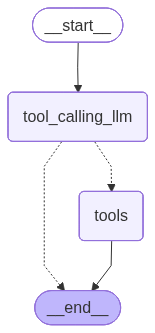

In [12]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


# Node definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Building Graph
builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges( # if the latest message from the tool_calling_llm(assistant) is a tool call  -> tool condition routes to tools otherwise routes to end
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)


graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
messages = graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (fc_d2175dcd-7608-4a40-8f75-cd9acf4aa69d)
 Call ID: fc_d2175dcd-7608-4a40-8f75-cd9acf4aa69d
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-03
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Ex

In [14]:
messages = graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================

**Machine learning (ML)** is a field of computer science that focuses on building systems that can learn from data, identify patterns, and make decisions or predictions with minimal human intervention.

---

### Core Idea
- **Learning from data**: Instead of being explicitly programmed for every possible scenario, an ML model is trained on a dataset. During training, it adjusts internal parameters (weights) to capture relationships in the data.
- **Generalization**: After training, the model is expected to perform well on new, unseen data that comes from the same underlying distribution.

### Key Components
| Component | What it Does |
|-----------|--------------|
| **Data** | The raw input (images, text, numbers, etc.) used for training. |
| **Model** | A mathematical representation (e.g., linear re